In [160]:
import numpy as np
from matplotlib.pylab import *
%matplotlib inline

# 1/𝞿 = (√5 - 1)/2
PHI_INVERSE = (np.math.sqrt(5)-1) / 2

# Part I
This portion is my attempt to implement the Golden Section Search as described on pages 7 and 8 in the following text:
https://nm.mathforcollege.com/mws/gen/09opt/mws_gen_opt_txt_goldensearch.pdf

In [161]:
def optimize_function_gs(f: "function", interval: ndarray, optIsMax: bool=True, epsilon: float=0.05) -> tuple:
    """
    Returns the optimal point's coordinates determined by the Golden Section Search for the given function within the interval.

    Parameters
      f - Function being optimized

      interval - Array containing the endpoints of the interval

      optIsMax - The optimal point is a maximum by default

      epsilon - The tolerance level the algorithm will stop at

    Returns
      Tuple containing optimal point's coordinates
    """
    # Initialize the lower bound and upper bound as xL and xU, respectively
    # Calculate the difference between the lower and upper bound (tolerance)
    xL, xU = interval
    tolerance = xU - xL
    
    # Calculate initial intermediate points using the boundaries, PHI_INVERSE and tolerance
    phi_inv_times_tolerance = PHI_INVERSE * tolerance
    x1 = xL + phi_inv_times_tolerance
    x2 = xU - phi_inv_times_tolerance
      
    while tolerance >= epsilon:
      # Evaluate the function at x1 and x2
      fx1 = f(x1)
      fx2 = f(x2)

      # Determine the new interval ([xL, x2, x1] or [x2, x1, xU]) based on the comparison between fx1
      # and fx2 and optIsMax's value
      # There are two cases for each one can be chosen from, but to simplify, this tests the conditions
      # to choose [x2, x1, xU]. Otherwise, [xL, x2, x1] is the new interval. The values are then updated accordingly.
      if (fx1 >= fx2 and optIsMax) or (fx1 < fx2 and not optIsMax):
        xL = x2
        x2 = x1
        x1 = xL + PHI_INVERSE*(xU-xL) 
      else:
        xU = x1
        x1 = x2
        x2 = xU - PHI_INVERSE*(xU-xL)  
      
      # Update tolerance
      tolerance = xU - xL

    # Calculate x coordinate of optimal point
    xOpt = (xU + xL) / 2

    # Evaluate the function at xOpt
    yOpt = f(xOpt)

    return xOpt, yOpt

Optimize the function $f(x) = 4\sin(x)(1 + \cos(x))$ with $\epsilon=0.05$ on the interval $[0, \pi/2]$ given that the optimum is a maximum.

In [162]:
def f(x: float) -> float:
  return 4*np.math.sin(x) * (1+np.math.cos(x))

interval = np.array([0, np.math.pi / 2])
xOpt, yOpt = optimize_function_gs(f, interval)

print(f"The optimal value is approximately {yOpt:0.5f} and corresponds to the x-value {xOpt:0.5f}.")

The optimal value is approximately 5.19599 and corresponds to the x-value 1.04162.


# Part II
Consider the Golden Section Search Method for the function $f(x)$ on the interval $[0,b]$. The method involves choosing a point $x$ where $0<x<b/2$, then evaluating $f(x)$ and $f(b-x)$.
If $f(x)<f(b-x)$, then the optimum is in the interval $[0,b-x]$.

Suppose $f(x)<f(b-x)$. Define $b'=b-x$. Then $0<x<b'$ is true as shown below:
$$0 < x < \frac{b}{2}$$
$$0 > -x > -\frac{b}{2}$$
$$b > b-x > b-\frac{b}{2}$$
$$b > b-x > \frac{b}{2}$$
However, it was given that $0<x<b/2$ which means
$$b > b-x > \frac{b}{2} > x > 0$$
Now substitute for $b-x$
$$b > b' > \frac{b}{2} > x > 0 \Rightarrow b' > x > 0$$
Or equivalently
$$0 < x < b'$$

Now, let $x'=\text{min}(x,b'-x)$ (note that according to this definition, $x' \le b'/2$). According to the algorithm, the next step involves finding $f(x')$ and $f(b'-x')$. Suppose $f(x')<f(b'-x')$. The optimum is in the interval $[0, b'-x']$. Define $b''=b'-x'$ and $x''=\text{min}(x',b''-x')$.

We repeat the process obtaining $b''',b''''$, etc always supposing that $f(x'\cdots')$ is the smaller of the two values. This produces a decreasing sequence $b',b'',b''',\dots$ corresponding to smaller and smaller intervals in which the root must be located.

In [163]:
def get_b_ratio_seq_arr(x_val_arr: ndarray, M: int, b: float) -> ndarray:
  """
  Produces a N by M array of values of b'/b, b''/b', b'''/b'',... for each initial point in
  x_val_arr given some value b, which is the upper bound in the interval [0, b].

  Parameters
    x_val_arr - Array containing x values that are the initial points

    M - The number of terms in the b-ratio sequence
    
    b - The upper bound in the interval [0, b]

  Returns
    N by M array containing the sequence of ratios for each value in x_val_arr
  """
  # Generate the N by M+1 zero array (b_arr). Each row contains the sequence [b, b', b'', ...]
  # based on the initial point.
  N = len(x_val_arr)
  b_arr = np.zeros((N, M + 1))

  # Each sequence always starts with b, so each entry in b_arr's first column is b.
  b_arr[:, 0] = b  

  for i in range(N):
    # Get the initial point from x_val_arr
    x = x_val_arr[i]

    for j in range(1, M + 1):
      # Definition of b^j
      b_arr[i, j] = b_arr[i, j - 1] - x

      # Definition of x^j
      x = min(x, b_arr[i, j] - x)
  
  # If each row in b_arr is [b, b', b'', b''', ...] and we need [b'/b, b''/b', b'''/b'', ...],
  # Numerator can be sliced from index 1 to the end: [b', b'', b''', ...]
  # Denominator can be sliced from index 0 to the second to last element: [b, b', b'', ...]
  # These ratios can be calculated by element-wise division for any row i: b_arr[i, 1:] / b_arr[i, :-1]
  # But, this division can be done by slicing b_arr. The result is a N by M array
  b_ratio_arr = b_arr[:, 1:] / b_arr[:, :-1]

  return b_ratio_arr

To test this, let $M=20$ and $b=1$. This means that the interval is $[0, 1]$ and we are generating the first 20 terms of the sequence: $b'/b, b''/b', ...$ for each x value. The initial points in this case will be 8 evenly spaced values between 0 and 1/2, exclusively.

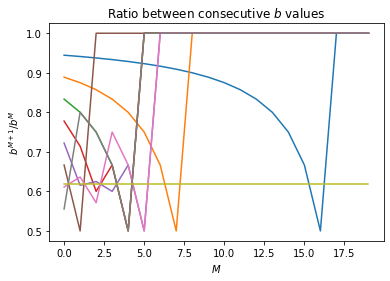

In [164]:
M = 20
b = 1

# Generate 10 values between 0 and b/2 but subset between the limits
x_values = np.linspace(0, b / 2, num = 10)[1:-1]

# 1-(1/𝞿) is a special value, so it will be added to the x_values array
one_minus_phi_inv = 1 - PHI_INVERSE
x_values = np.append(x_values, one_minus_phi_inv)

# Generate the b_ratio_arr based on the given
b_ratio_arr = get_b_ratio_seq_arr(x_values, M, b)

# Generate the x_axis values
x_axis = np.arange(M)

# Plot the b ratio sequence for every initial point on the same x_axis
for i in range(len(x_values)):
  plot(x_axis, b_ratio_arr[i, :])
title("Ratio between consecutive $b$ values")
ylabel("$b^{M+1}/b^{M}$")
xlabel("$M$")
show()

# Why is $1-1/\varphi$ special?
In the previous plot, there are some initial points whose $b^{M+1}/b^M$ decreases initially but then spike to 1. This means that the interval is shrinking; however, at some point, the interval stops shrinking overall. On the other hand, some initial points have ratios that increase and decrease but still spike to 1.

But, notice how there's one line that's constant. This means that one initial point stabilized the ratio $b^{M+1}/b^M$ meaning that the interval is shrinking each time but by the same factor. It turns out that initial point is $1-1/\varphi$. Why is this?

If one runs through the algorithm, the intervals turn out to be the following:
$$\left[0,1\right] \Rightarrow \left[0,\frac{1}{\varphi}\right] \Rightarrow \left[0,\frac{1}{\varphi^{2}}\right] \Rightarrow \left[0,\frac{1}{\varphi^{3}}\right]$$

The length of each interval is $1$, $1/\varphi$, $1/\varphi^{2}$, and $1/\varphi^{3}$, respectively. As shown in the next cell, the b sequence is exactly the same as the lengths mentioned:
$$b=1, b'=\frac{1}{\varphi}, b''=\frac{1}{\varphi^{2}}, b'''=\frac{1}{\varphi^{3}}$$

Now compare the ratios with one another
$$\frac{b'}{b}=\frac{\frac{1}{\varphi}}{1}=\frac{1}{\varphi}$$
$$\frac{b''}{b'}=\frac{\frac{1}{\varphi^{2}}}{\frac{1}{\varphi}}=\frac{1}{\varphi}$$
$$\frac{b'''}{b''}=\frac{\frac{1}{\varphi^{3}}}{\frac{1}{\varphi^{2}}}=\frac{1}{\varphi}$$

This shows that the exact ratio $b^{M+1}/b^M$ stays on is $1/\varphi$ when the initial point is $1-1/\varphi$.

$1/\varphi$ is the exact value used in the Golden Section Search Algorithm.

# In case the math is wanted...

Since the interval was $[0, 1]$, we follow the golden section search algorithm as specified earlier:

$$b=1, x=1-\frac{1}{\varphi}$$

The interval would be $[0, b-x]$ so
$$\left[0, 1-\left(1-\frac{1}{\varphi}\right)\right] \Rightarrow \left[0, \frac{1}{\varphi}\right]$$

Repeat process for the next interval
$$b'=b-x=\frac{1}{\varphi}$$
$$x'=\min(x,b'-x)=\min\left(1-\frac{1}{\varphi},\frac{1}{\varphi}-\left(1-\frac{1}{\varphi}\right)\right)=\min\left(1-\frac{1}{\varphi},\frac{2}{\varphi}-1\right)=\frac{2}{\varphi}-1$$

The new interval would be $[0, b'-x']$ or

$$[0,b'-x'] \Rightarrow \left[0, \frac{1}{\varphi} - \left(\frac{2}{\varphi}-1\right)\right] \Rightarrow \left[0, 1-\frac{1}{\varphi}\right] \Rightarrow \left[0, \frac{1}{\varphi^{2}}\right]$$

Repeat one more time
$$b''=b'-x'=\frac{1}{\varphi^{2}}$$
$$x''=\min(x',b''-x')=\min\left(\frac{2}{\varphi}-1,\frac{1}{\varphi}-\left(\frac{2}{\varphi}-1\right)\right)=\min\left(\frac{2}{\varphi}-1,\frac{1}{\varphi^{2}}-\frac{2}{\varphi}+1\right)=\frac{1}{\varphi^{2}}-\frac{2}{\varphi}+1$$

The new interval would be $[0, b''-x'']$ or

$$[0,b''-x''] \Rightarrow \left[0, \frac{1}{\varphi^{2}} - \left(\frac{1}{\varphi^{2}}-\frac{2}{\varphi}+1\right)\right] \Rightarrow \left[0, \frac{2}{\varphi}-1\right] \Rightarrow \left[0, \frac{1}{\varphi^{3}} \right]$$

If we keep going then $b'''=1/\varphi^{3}$